## This book conducts sentiment clustering on speakers in the UN OEWG meeting. It assigns various countries to different clusters and highlights the topic of focus in the different clusters.

In [121]:
#import libraries
#reading api key
from dotenv import dotenv_values
#reading data
import pandas as pd
#data preprocessing
import re
import numpy as np
import ast
#clustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
#topic generation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from openai import OpenAI
import networkx as nx

In [60]:
#import openai credentials
config = dotenv_values('credential.env')
openai_key = config['openai_api_key']
openai_deployment_name = "gpt-4"

## First Step

This step includes data cleaning and preparation.
1. The embeddings were carried out with a dynmaic embedding model (sentence-transformers/all-mpnet-base-v2)which captures the semantic and contextual relationship among speech spoken by each speaker. The text embeddings was already included in the csv

2. Remove all speech spoken by the chairman and all individual representatives

3. Ensure each country is represented with only one name. eg (the united states, US is all converted to united states)

4. Convert the values in text embedding columns from string type to list of vectors





In [96]:
df = pd.read_csv('/content/un_oewg_meetings.csv')
df.head()

,Id,Session,Meeting,Speaker,Text,TextEmbeddings
0,S2M31_1,2,3,Chairman,"Dear colleagues, Excellencies, please take you...","[0.06515908241271973, -0.009579229168593884, 0..."
1,S2M31_2,2,3,Chairman,"we will focus. On discussions on topic 2, Curr...","[0.0666637122631073, 0.03770853951573372, 0.02..."
2,S2M31_3,2,3,Chairman,of the National Academy of Political and Strat...,"[-0.0026448278222233057, 0.117243193089962, 0...."
3,S2M32_1,2,3,The Secure World Foundation,"Thank you, Mr. Chair. My name is Victoria Samp...","[0.050753768533468246, 0.08790837973356247, 0...."
4,S2M32_2,2,3,The Secure World Foundation,to develop and promote international cooperati...,"[0.07907143235206604, -0.009904933162033558, 0..."


In [97]:
#remove all rows with "Chairman" in the speaker column and store in a new df
df_updated = df[df['Speaker'] != 'Chairman']
#get the number of rows
print(f' number of rows is {df_updated.shape[0]}')

 number of rows is 7998


In [98]:
# Delete row where 'speaker' column contains a specific string
df_updated = df_updated[df_updated['Speaker'] != '\ufeffChairman']

In [99]:
 # Delete rows where 'speaker' column containing individual representations
df_updated = df_updated[~df_updated['Speaker'].isin(['thank you, Mr. President, and thank you, dear German delegate, for this question. I hope I understood it correctly. To what extent, as far as I understand, you asked this question. The Chekhov Convention and other agreements have a position that interact and that rely on each other or are restricted from each other. This is related to understanding the articles in this agreement. I am assuming that... in order to... well, in the space agreement it is based on the usual international law and many positions coincide with the positions of other agreements and agreements. But it is a little more limited. And of course, as it is the Chekhov Convention, the right to space is based on the Chekhov Convention. Chairman'])]

In [100]:
# Delete rows where 'speaker' column containing individual representations
df_updated = df_updated[~df_updated['Speaker'].isin(['NAROOJ','Dr. Suzuki', 'Mr. James Black', 'Professor Wang' ,'Mr. Clinton Clark','Professor Kazuto Suzuki',
 'Mr. Black','Doctor Bowen', 'Doctor Gregor.', 'Mr. Stefanovich' ,'Doctor Gregor', 'Mr. Bertolotti', 'Mr. Vignetti',
 'Miss. Elena Mozarova' ,'Miss Elina Morozova', 'Mr. Lena Morozova' ,'Mr. Moto Vinati' ,'Miss Alina Morozova'
 'Mr. Mauro Vignetti', 'Mr. David Bertolotti','Doctor Bown', 'Doctor Brown', 'Mr. Dimitri Stefanovic', 'Doctor Grego' ,'Doctor. Bone', 'Mr. Stefanovic','Miss Alina Morozova' ,'Mr. Mauro Vignetti', 'Chairma', 'Dr. Suzuki' 'Mr. James Black' 'Professor Wang'
 'Mr. Clinton Clark' 'Uruguay' 'Mr. Clark' 'Professor Kazuto Suzuki','\ufeffChairman', 'Doctor Bown' 'Doctor Brown'
 'Mr. Dimitri Stefanovic' 'Doctor Grego' 'Doctor. Bone' 'Mr. Stefanovic'
 'Doctor Bowen' 'Doctor Gregor.' 'Mr. Stefanovich' 'Doctor Gregor', 'Mr. Bertolotti' 'Mr. Vignetti' 'Miss. Elena Mozarova'
 'Miss Elina Morozova' 'Mr. Lena Morozova' 'Mr. Moto Vinati'
 'Miss Alina Morozova' 'Mr. Mauro Vignetti' 'Mr. David Bertolotti','Mr. Clark'])]

In [101]:
# Print all unique values in the 'speaker' column
print(df_updated['Speaker'].unique())

['The Secure World Foundation' 'Unidir' 'Chile' 'The Russian Federation'
 'The United Kingdom' 'The United States' 'Australia' 'Germany'
 'The Australian Center for Space Governance' 'Cambodia' 'European Union'
 'Russian Federation' 'Philippines' 'Japan' 'China' 'United Kingdom'
 'France' 'Norway' 'Italy' 'Switzerland' 'The Republic of Korea' 'Canada'
 'Spain' 'Brazil' 'Uruguay' 'Austria' 'The Observer Research Foundation'
 'The Hillasa Center Institute of Physics of the Czech Academy of Science'
 'The Japan Space Policy at Astro Scale' 'Cuba' 'Russia'
 'The Islamic Republic of Iran' 'The Czech Academy of Science' 'Malaysia'
 'Peru' 'UAE' 'Indonesia' 'Egypt' 'Thailand' 'Turkey' 'Algeria' 'Colombia'
 'Pakistan' 'Argentina' 'North Korea' 'USA' 'South Korea' 'Belgium'
 'Mexico' 'Sri Lanka' 'Sweden' 'New Zealand' 'India' 'Ireland'
 'Saudi Arabia' 'ICRC' 'the Russian Federation' 'Poland' 'Netherlands'
 'Israel' 'The Islamic Republic of Iran:18' 'Portugal'
 'Philippines (Multi-Country)' 'EU'

In [102]:
# Unify Russia's name in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['Russian Federation','Russian', 'The Russian Federation','the Russian Federation'], 'Russia')

In [103]:
# Unify United States's name in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['The United States', 'USA'], 'United States')

In [104]:
# Unify United kingdom's name in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['The United Kingdom', 'UK'], 'United Kingdom')

In [105]:
# Unify Iran's name in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['The Islamic Republic of Iran', 'The Islamic Republic of Iran:18'], 'Iran')

In [106]:
# Unify UAE's name in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['United Arab Emirates', 'The United Arab Emirates'], 'UAE')

In [107]:
# Print all unique values in the 'speaker' column
print(df_updated['Speaker'].unique())

['The Secure World Foundation' 'Unidir' 'Chile' 'Russia' 'United Kingdom'
 'United States' 'Australia' 'Germany'
 'The Australian Center for Space Governance' 'Cambodia' 'European Union'
 'Philippines' 'Japan' 'China' 'France' 'Norway' 'Italy' 'Switzerland'
 'The Republic of Korea' 'Canada' 'Spain' 'Brazil' 'Uruguay' 'Austria'
 'The Observer Research Foundation'
 'The Hillasa Center Institute of Physics of the Czech Academy of Science'
 'The Japan Space Policy at Astro Scale' 'Cuba' 'Iran'
 'The Czech Academy of Science' 'Malaysia' 'Peru' 'UAE' 'Indonesia'
 'Egypt' 'Thailand' 'Turkey' 'Algeria' 'Colombia' 'Pakistan' 'Argentina'
 'North Korea' 'South Korea' 'Belgium' 'Mexico' 'Sri Lanka' 'Sweden'
 'New Zealand' 'India' 'Ireland' 'Saudi Arabia' 'ICRC' 'Poland'
 'Netherlands' 'Israel' 'Portugal' 'Philippines (Multi-Country)' 'EU'
 'Singapore' 'Venezuela' 'Hungary' 'The Russian Academy of Sciences'
 'The Massachusetts Institute of Technology' 'Secretary' 'Hong' 'French'
 'Denmark' 'Preside

In [108]:
df_updated.head()

,Id,Session,Meeting,Speaker,Text,TextEmbeddings
3,S2M32_1,2,3,The Secure World Foundation,"Thank you, Mr. Chair. My name is Victoria Samp...","[0.050753768533468246, 0.08790837973356247, 0...."
4,S2M32_2,2,3,The Secure World Foundation,to develop and promote international cooperati...,"[0.07907143235206604, -0.009904933162033558, 0..."
5,S2M32_3,2,3,The Secure World Foundation,"to be here on the panel to discuss Topic 2, Cu...","[0.0647539347410202, -0.02068813517689705, 0.0..."
6,S2M32_4,2,3,The Secure World Foundation,space environment and on the space based activ...,"[0.09294697642326355, 0.031632017344236374, 0...."
7,S2M32_5,2,3,The Secure World Foundation,freely available to all titled. Global counter...,"[0.08138876408338547, 0.014677620492875576, 0...."


In [109]:
# use the dtype attribute of the DataFrame
column_dtype = df_updated.dtypes['TextEmbeddings']

# Print the data type
print(column_dtype)

object


In [116]:
# Access the first element of the 'TextEmbeddings' column
value = df_updated['TextEmbeddings'].iloc[0]
value_type = type(value)
print(value_type)

<class 'str'>


In [117]:
# Convert string representations of lists to actual lists
df_updated['TextEmbeddings'] = df_updated['TextEmbeddings'].apply(lambda x: ast.literal_eval(x))


In [118]:
# Access the first element of the 'TextEmbeddings' column
value = df_updated['TextEmbeddings'].iloc[0]
value_type = type(value)
print(value_type)

<class 'list'>


## Second step

This step includes carrying out the analysis and clustering.

1. Carry out a cosine similarity among all the speeches by countries

2. based on the similarity matrix, use spectral clustering to assign speeches spoken by diffeerent countries to different clusters.

3. Label each country based on their cluster label assigned

4. Visualize how each country is clustered.

In [123]:
# Compute cosine similarity matrix
contextual_embeddings = np.stack(df_updated['TextEmbeddings'].to_numpy())
cosine_sim_matrix = cosine_similarity(contextual_embeddings, contextual_embeddings)


In [124]:
# Perform Spectral Clustering
n_clusters = 5
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
cluster_labels = spectral_clustering.fit_predict(cosine_sim_matrix)

In [125]:
# Add cluster labels to the original DataFrame
df_updated['cluster_label'] = cluster_labels
df_updated.head()

,Id,Session,Meeting,Speaker,Text,TextEmbeddings,cluster_label
3,S2M32_1,2,3,The Secure World Foundation,"Thank you, Mr. Chair. My name is Victoria Samp...","[0.050753768533468246, 0.08790837973356247, 0....",0
4,S2M32_2,2,3,The Secure World Foundation,to develop and promote international cooperati...,"[0.07907143235206604, -0.009904933162033558, 0...",3
5,S2M32_3,2,3,The Secure World Foundation,"to be here on the panel to discuss Topic 2, Cu...","[0.0647539347410202, -0.02068813517689705, 0.0...",4
6,S2M32_4,2,3,The Secure World Foundation,space environment and on the space based activ...,"[0.09294697642326355, 0.031632017344236374, 0....",0
7,S2M32_5,2,3,The Secure World Foundation,freely available to all titled. Global counter...,"[0.08138876408338547, 0.014677620492875576, 0....",0


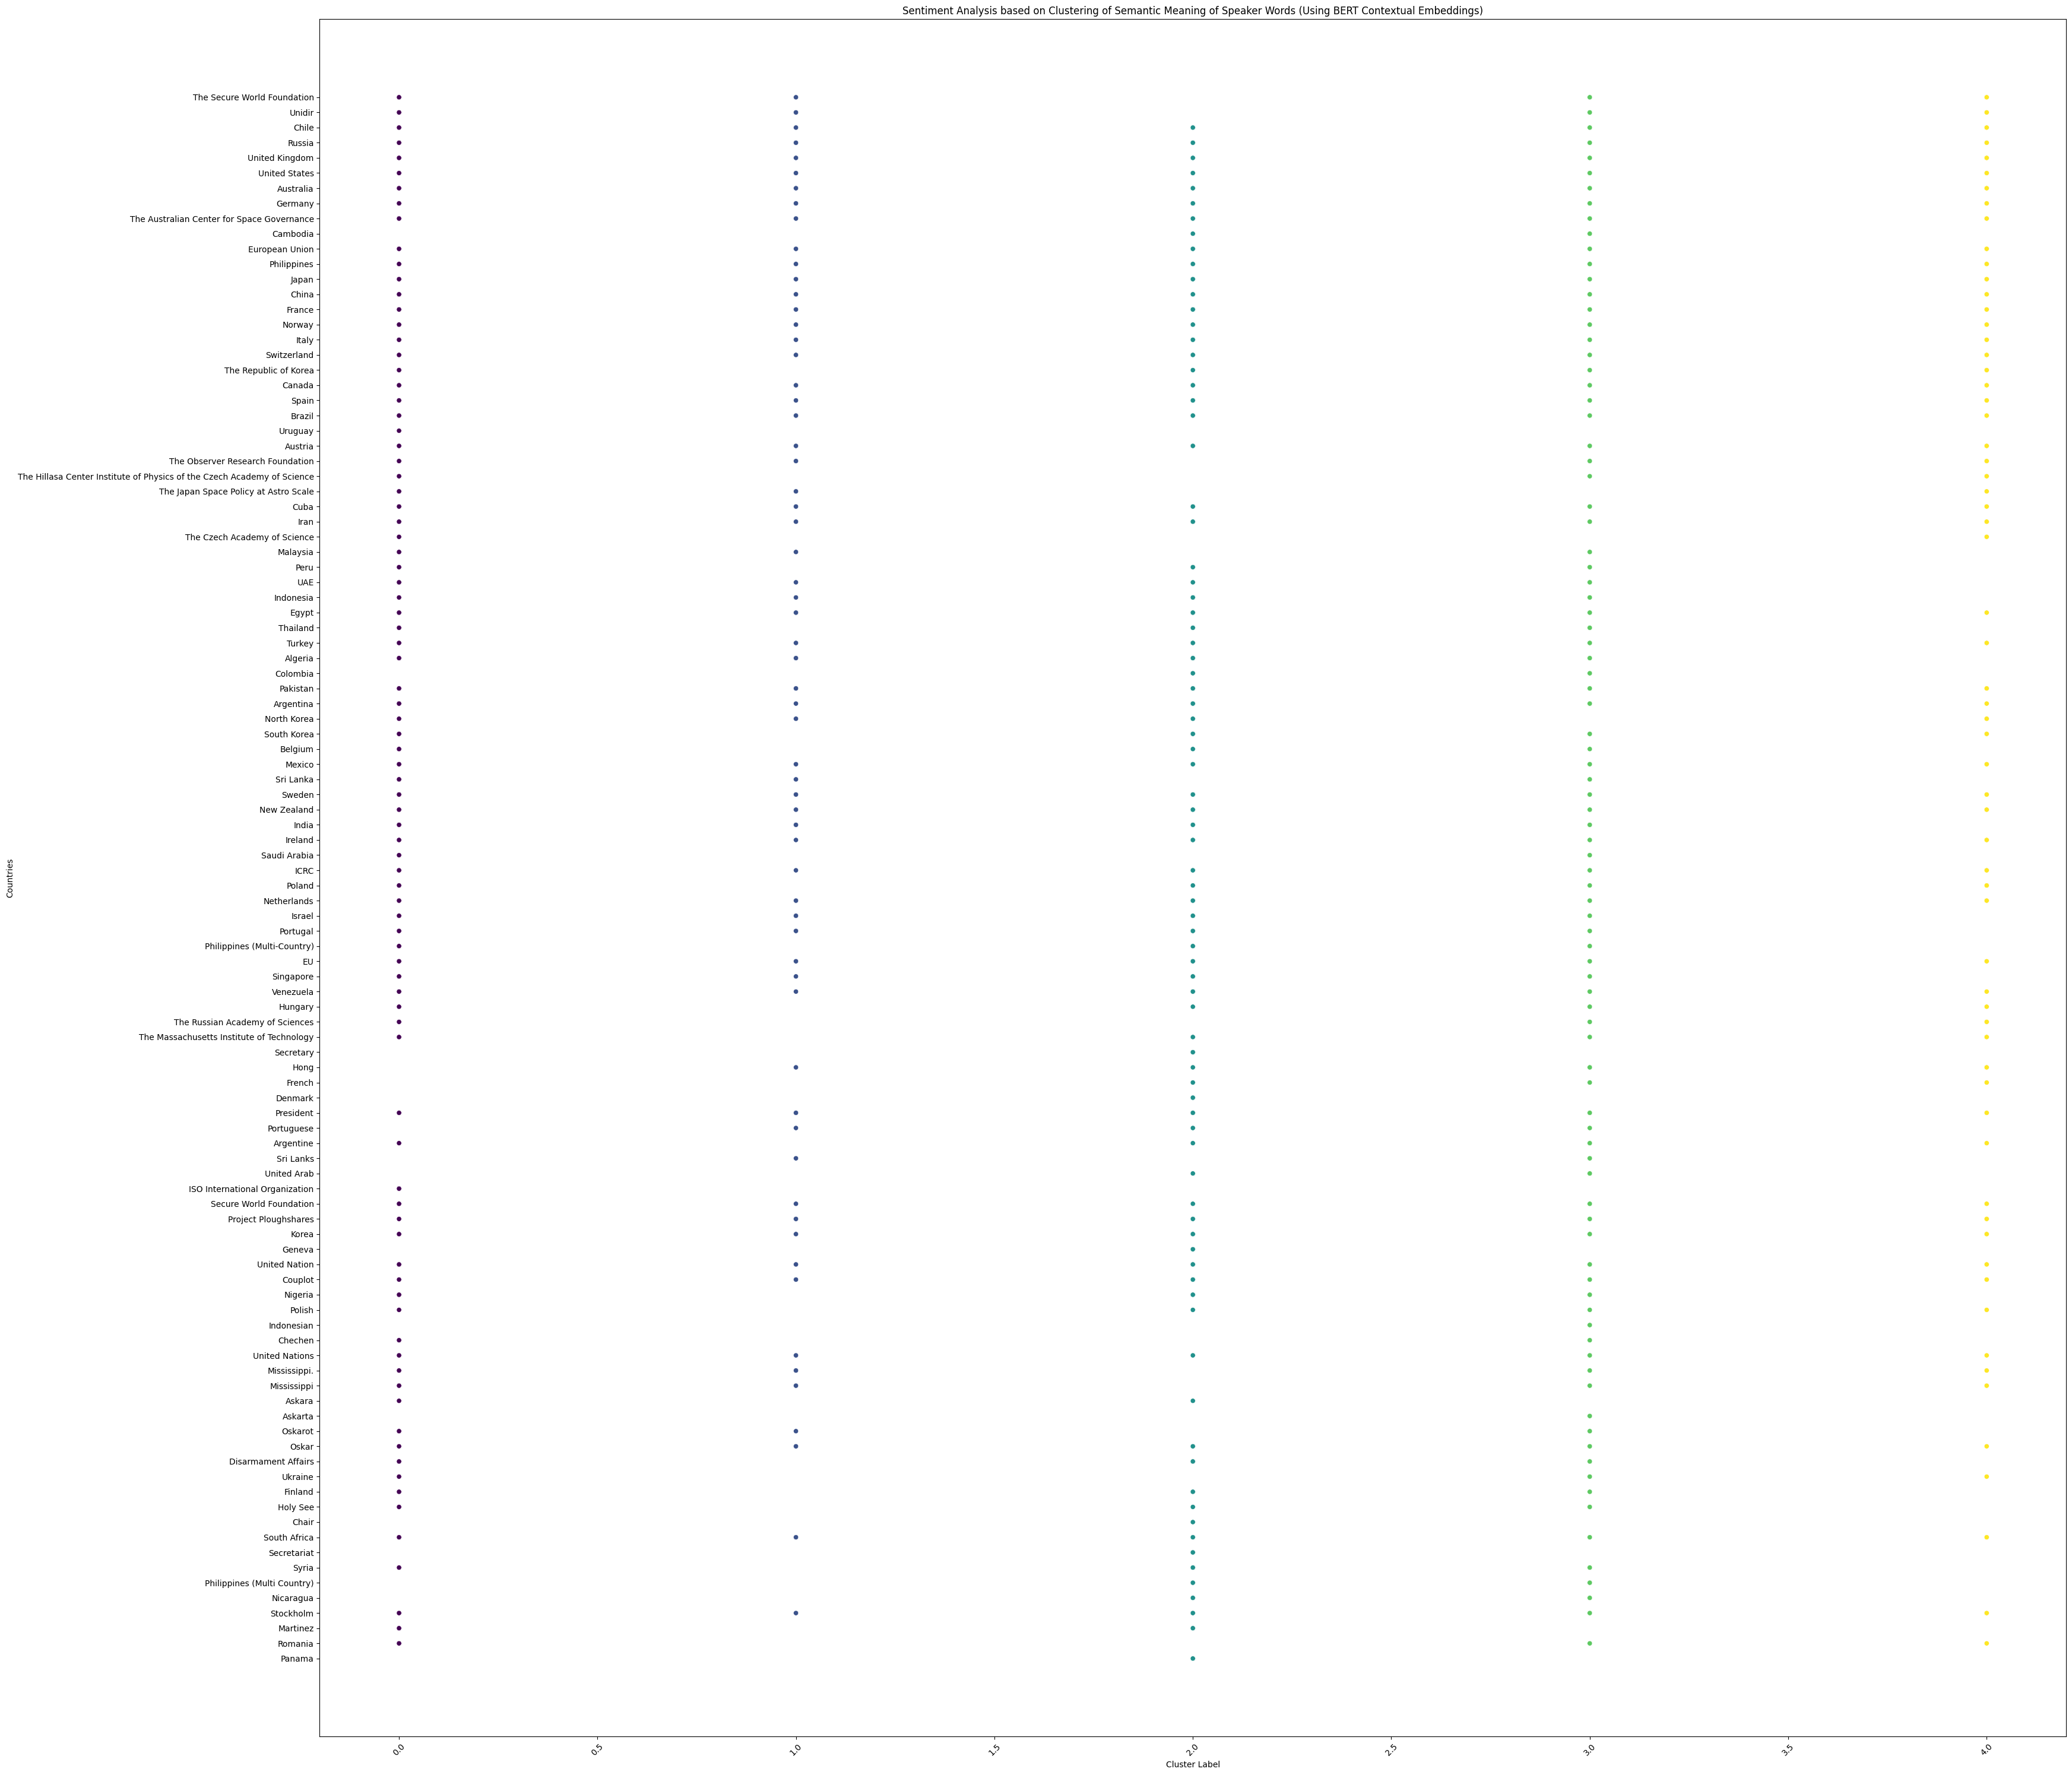

In [126]:
# Visualize the clustering results
plt.figure(figsize=(35, 30))
sns.scatterplot(data=df_updated, x='cluster_label', y='Speaker', hue='cluster_label', palette='viridis', legend=False)
plt.title('Sentiment Analysis based on Clustering of Semantic Meaning of Speaker Words (Using BERT Contextual Embeddings)')
plt.xticks(rotation=45)
plt.xlabel('Cluster Label')
plt.ylabel('Countries')
plt.tight_layout()
plt.show()

## Third Step.

This step uses topic modelling to identify the topic of each cluster .

1. It uses TF-IDF Vectorizer to convert the text, then uses the non-negative matrix factorization to extract the topic names and returns the topics.

2. Uses OpenAI gpt-4 to construct the topics into sentences.

3. Each cluster, their topics of focus and countries in the clusters are printed

4. A final clustered dataframe is merged with the initial dataframe  and a final csv is returned and saved

In [148]:
# Function to conduct topic modeling on a cluster
def conduct_topic_modeling(cluster_data):
    # Extract text data for the cluster
    cluster_text = cluster_data['Text'].values

    # Vectorize the text data using TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(cluster_text)

    # Apply Non-negative Matrix Factorization (NMF) for topic modeling
    nmf = NMF(n_components=2, random_state=42)
    W = nmf.fit_transform(X)

    # Get the feature names (words from vocabulary)
    feature_names = vectorizer.get_feature_names_out()

    # Print the top words for each topic
    topics = []
    for topic_idx, topic in enumerate(nmf.components_):
        top_words_idx = topic.argsort()[::-1][:10]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
    return topics

In [128]:
client = OpenAI(api_key=openai_key)


def prompt_engineering(topics):
    chat_context_prompt = f"With the words provided, what is the topic of discussion {topics}"
    return chat_context_prompt

def topic_generation(topics):
    chat_context_prompt = prompt_engineering(topics)
    MESSAGES = [
        {"role": "system", "content": chat_context_prompt},
        {"role": "user", "content": ""}
    ]

    completion = client.chat.completions.create(
        model=openai_deployment_name,
        messages=MESSAGES,
        temperature=0.6,
        max_tokens=200
    )

    return completion.choices[0].message.content

In [149]:
# Iterate over each cluster
for cluster_id in range(n_clusters):
    print(f"Cluster {cluster_id}:")
    cluster_data = df_updated[df_updated['cluster_label'] == cluster_id]
    # Get unique countries in the cluster
    unique_countries = cluster_data['Speaker'].unique()
    print("Countries:", ", ".join(unique_countries))
    topics = conduct_topic_modeling(cluster_data)
    print("Topics:", topics)
    print(topic_generation(topics))

Cluster 0:
Countries: The Secure World Foundation, Unidir, Chile, United Kingdom, Australia, Germany, The Australian Center for Space Governance, European Union, Philippines, Japan, Russia, France, Norway, Italy, United States, Switzerland, The Republic of Korea, Canada, Spain, Brazil, Uruguay, Austria, The Observer Research Foundation, The Hillasa Center Institute of Physics of the Czech Academy of Science, The Japan Space Policy at Astro Scale, China, Iran, The Czech Academy of Science, Malaysia, Peru, UAE, Indonesia, Cuba, Thailand, Algeria, Pakistan, Argentina, North Korea, Belgium, Mexico, Egypt, Sri Lanka, Sweden, New Zealand, India, Ireland, Saudi Arabia, ICRC, Turkey, Poland, Netherlands, Israel, Portugal, Philippines (Multi-Country), EU, Singapore, South Korea, Venezuela, Hungary, The Russian Academy of Sciences, The Massachusetts Institute of Technology, Argentine, ISO International Organization, Secure World Foundation, Project Ploughshares, United Nation, Couplot, Korea, Ni

In [133]:
#save the df_updated into a csv file in the csv folder
df_updated.to_csv('/content/un_oewg_meeting_sentiment_analysis.csv', index=False)

In [136]:
# Merge df with df_updated based on 'id' column
merged_df = pd.merge(df, df_updated[['Id', 'cluster_label']], on='Id', how='left')
# Fill missing cluster labels with 'not assigned'
merged_df['cluster_label'] = merged_df['cluster_label'].fillna('not assigned')
merged_df.head()

,Id,Session,Meeting,Speaker,Text,TextEmbeddings,cluster_label
0,S2M31_1,2,3,Chairman,"Dear colleagues, Excellencies, please take you...","[0.06515908241271973, -0.009579229168593884, 0...",not assigned
1,S2M31_2,2,3,Chairman,"we will focus. On discussions on topic 2, Curr...","[0.0666637122631073, 0.03770853951573372, 0.02...",not assigned
2,S2M31_3,2,3,Chairman,of the National Academy of Political and Strat...,"[-0.0026448278222233057, 0.117243193089962, 0....",not assigned
3,S2M32_1,2,3,The Secure World Foundation,"Thank you, Mr. Chair. My name is Victoria Samp...","[0.050753768533468246, 0.08790837973356247, 0....",0.0
4,S2M32_2,2,3,The Secure World Foundation,to develop and promote international cooperati...,"[0.07907143235206604, -0.009904933162033558, 0...",3.0


In [137]:
# check the number of rows
num_rows = df.shape[0]
mergednum_rows = merged_df.shape[0]
print("Number of rows in the DataFrame:", num_rows)
print("Number of rows in the DataFrame:", mergednum_rows)


Number of rows in the DataFrame: 9379
Number of rows in the DataFrame: 9379


In [138]:
#save the df_updated into a csv file in the csv folder
merged_df.to_csv('/content/un_oewg_meeting_sentiment_analysis.csv', index=False)